In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

import pandas as pd

def make_scheduler(coeff: float, mode: str = 'linear', step=10):
    """Creates a learning rate scheduler."""
    if mode == 'linear':
        def scheduler(epoch: int, lr: float) -> float:
            return lr if epoch < step else max(lr * coeff, 1e-7)
        return scheduler
    elif mode == 'decay':
        def scheduler(epoch: int, lr: float) -> float:
            return lr * (1 + coeff * epoch) / (1 + coeff * (epoch + 1))
        return scheduler
    else:
        raise ValueError(f"Unsupported mode: {mode}. Only 'linear' and 'decay' are supported.")

In [2]:
# Load the boundary dataset
boundary_file_training = './data/reaction_diffusion_boundary_training.h5'
boundary_file_testing = './data/reaction_diffusion_boundary_testing.h5'
pod_modes_file = './data/pod_basis.h5'

with h5py.File(boundary_file_training, 'r') as h5file:
    u_boundary_train = h5file['u_boundary'][:]  # Shape: (num_samples, time_steps, boundary_features)


with h5py.File(boundary_file_testing, 'r') as h5file:
    u_boundary_test = h5file['u_boundary'][:]  # Shape: (num_samples, time_steps, boundary_features)

with h5py.File(pod_modes_file, 'r') as h5file:
    POD_modes = h5file['POD_modes'][:, :11]  # First 11 modes
    Sigma = h5file['singular_values'][:11]
    
# Load the HDF5 dataset
filename = './data/reaction_diffusion_training.h5'
with h5py.File(filename, 'r') as h5file:
    u_data = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data.shape[0]} samples.")

# Load the HDF5 dataset
filename = './data/reaction_diffusion_testing.h5'

with h5py.File(filename, 'r') as h5file:
    u_data_test      = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data_test.shape[0]} samples.")

training_data = pd.read_csv('./data/pod_coefficients_training_dataset.csv').values  # Only inputs
testing_data = pd.read_csv('./data/pod_coefficients_testing_dataset.csv').values  # Only inputs

Loaded dataset with 50 samples.
Loaded dataset with 50 samples.


In [3]:
# Compute POD coefficients for each time step
num_samples, time_steps, n, _ = u_data.shape
snapshots = u_data.reshape(num_samples * time_steps, n * n).T  # Flatten spatial grid
pod_coefficients = (POD_modes.T @ snapshots) / Sigma[:, None]  # Shape: (11, num_samples * time_steps)
pod_coefficients = pod_coefficients.T.reshape(num_samples, time_steps, 11)  # Reshape to match (samples, time_steps, modes)


In [4]:
snapshots_test = u_data_test.reshape(num_samples * time_steps, n * n).T  # Flatten spatial grid
pod_coefficients_test = (POD_modes.T @ snapshots_test) / Sigma[:, None]  # Shape: (11, num_samples * time_steps)
pod_coefficients_test = pod_coefficients_test.T.reshape(num_samples, time_steps, 11)  # Reshape to match (samples, time_steps, modes)


In [5]:
training_data=training_data.reshape((num_samples,time_steps,3))
testing_data=testing_data.reshape((num_samples,time_steps,3))
                             
print(u_boundary_train.shape)
print(training_data.shape)

(50, 1601, 32)
(50, 1601, 3)


In [6]:
print(training_data[1])

[[7.58794548e-02 1.09865848e+00 0.00000000e+00]
 [7.58794548e-02 1.09865848e+00 5.00000000e-02]
 [7.58794548e-02 1.09865848e+00 1.00000000e-01]
 ...
 [7.58794548e-02 1.09865848e+00 7.99000000e+01]
 [7.58794548e-02 1.09865848e+00 7.99500000e+01]
 [7.58794548e-02 1.09865848e+00 8.00000000e+01]]


In [7]:
# Combine boundary data for LSTM input
X_train = np.concatenate([u_boundary_train, training_data], axis=-1)  # Shape: (num_samples, time_steps, boundary_features * 2)
X_test = np.concatenate([u_boundary_test, testing_data], axis=-1)  # Shape: (num_samples, time_steps, boundary_features * 2)

y_train = pod_coefficients
y_test = pod_coefficients_test

In [8]:
# Standardize the inputs and outputs
input_scaler = StandardScaler()
output_scaler = StandardScaler()

# Flatten and scale boundary data
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = input_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = input_scaler.transform(X_test_flat).reshape(X_test.shape)

# Flatten and scale POD coefficients
y_train_flat = y_train.reshape(-1, y_train.shape[-1])
y_test_flat = y_test.reshape(-1, y_test.shape[-1])

y_train_scaled = output_scaler.fit_transform(y_train_flat).reshape(y_train.shape)
y_test_scaled = output_scaler.transform(y_test_flat).reshape(y_test.shape)

In [ ]:
# Define the LSTM model
model = Sequential([
    Dense(128,activation='gelu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(128,activation='gelu'),
    LSTM(128, activation='tanh', return_sequences=True),
    LSTM(128, activation='tanh', return_sequences=True),
    Dense(128,activation='gelu'),
    Dense(128,activation='gelu'),
    Dense(11, activation='linear')  # Predict 11 modes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=5,
    callbacks=[LearningRateScheduler(make_scheduler(0.99,step=1))],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1601, 128)      │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1601, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1601, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1601, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1601, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1601, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1601, 11)       │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,731 (1.22 MB)

 Trainable params: 318,731 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.8477 - mae: 0.6664 - val_loss: 0.6301 - val_mae: 0.5502 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.7487 - mae: 0.5818 - val_loss: 0.4958 - val_mae: 0.4790 - learning_rate: 9.9000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.6089 - mae: 0.5059 - val_loss: 0.3896 - val_mae: 0.4204 - learning_rate: 9.8010e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.4974 - mae: 0.4500 - val_loss: 0.2881 - val_mae: 0.3550 - learning_rate: 9.7030e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.3286 - mae: 0.3584 - val_loss: 0.2059 - val_mae: 0.2995 - learning_rate: 9.6060e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3065 - mae: 0.3429 - val_loss: 0.1477 - val_mae: 0.2529 - learning_rate: 9.5099e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.2001 - mae: 0.2741 - val_loss: 0.1148 - val_mae: 0.2223 - learning_rate: 

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.yscale('log')


NameError: name 'plt' is not defined

In [55]:
snapshot_plot = snapshots_test.T.reshape(num_samples,time_steps,n*n)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
Sample 1
True Modes: [-0.00635285  0.00700021  0.00528016 -0.00369826 -0.00969974 -0.00052182
  0.00215029  0.00459098 -0.00020232  0.00524279  0.00031329]
Predicted Modes: [-0.00613838  0.00709354  0.00529458 -0.00434857 -0.01018321 -0.00116058
  0.0022314   0.00467197 -0.00028796  0.00500528  0.00051992]


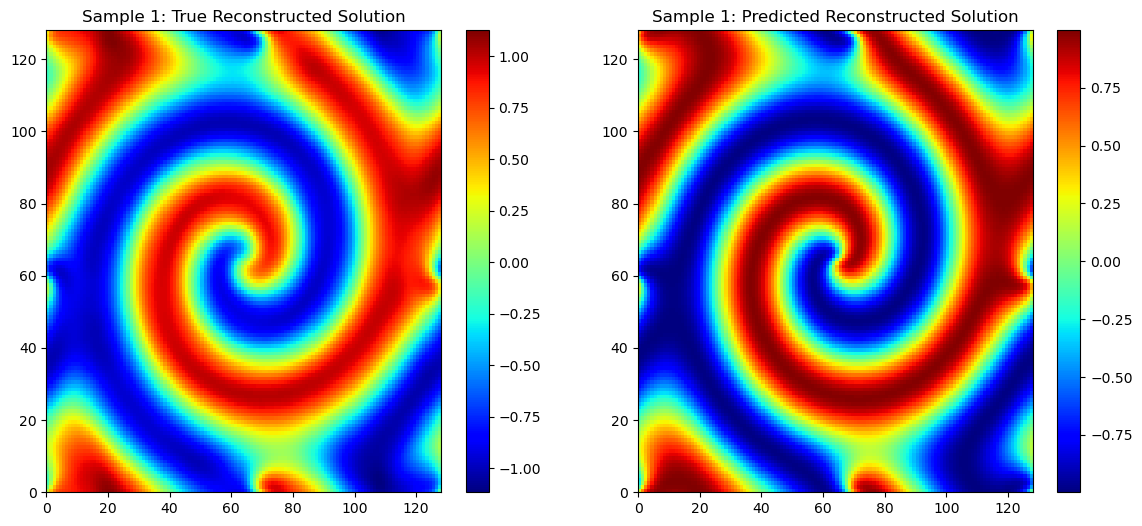

Sample 2
True Modes: [-0.00636776 -0.00307396  0.00946359  0.00103041 -0.01194684  0.02003116
  0.00660943 -0.00565059  0.00330687 -0.00141277  0.0028921 ]
Predicted Modes: [-0.00581128 -0.0030441   0.00958528  0.00098534 -0.01254681  0.01967624
  0.00731624 -0.00505403  0.00325174 -0.00141902  0.00322295]


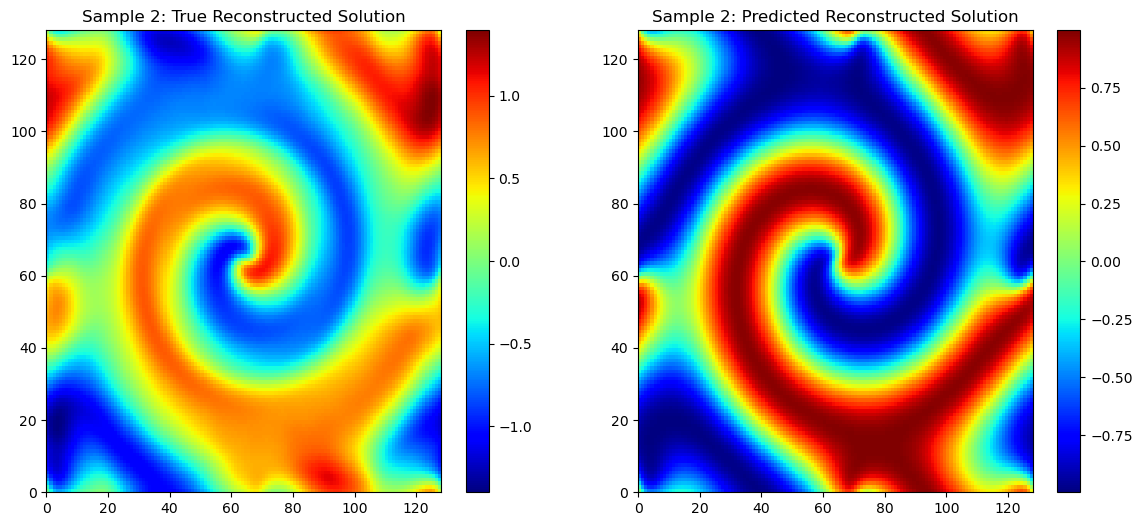

Sample 3
True Modes: [-0.00433973  0.001921   -0.00073964 -0.01570899  0.01499562  0.0069943
  0.0183362   0.01061111  0.00201009  0.00204187  0.01596669]
Predicted Modes: [-0.00393589  0.0011038  -0.00074445 -0.0145718   0.01528252  0.0062944
  0.01824729  0.01099988  0.00130569 -0.00046738  0.01454973]


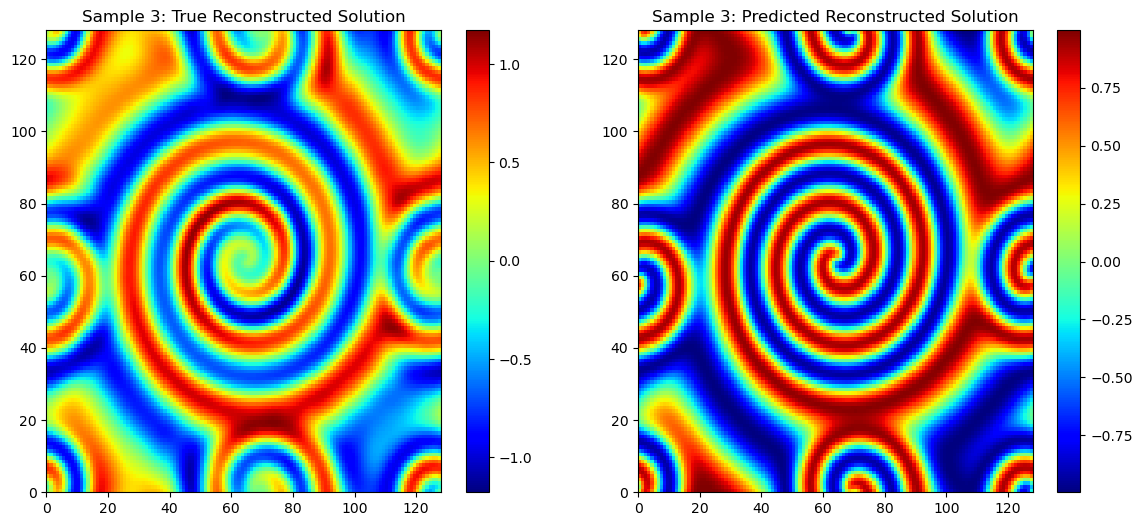

Sample 4
True Modes: [ 0.00088522 -0.00160883  0.00050313  0.01249666 -0.02294762 -0.00348083
 -0.02717785 -0.00733526 -0.00987863 -0.01314663 -0.00992142]
Predicted Modes: [ 6.4844712e-06 -1.2872950e-03 -8.6032134e-04  1.1563272e-02
 -2.1527484e-02 -3.2428992e-03 -2.6677975e-02 -6.5780259e-03
 -1.0750698e-02 -1.1271409e-02 -5.2551050e-03]


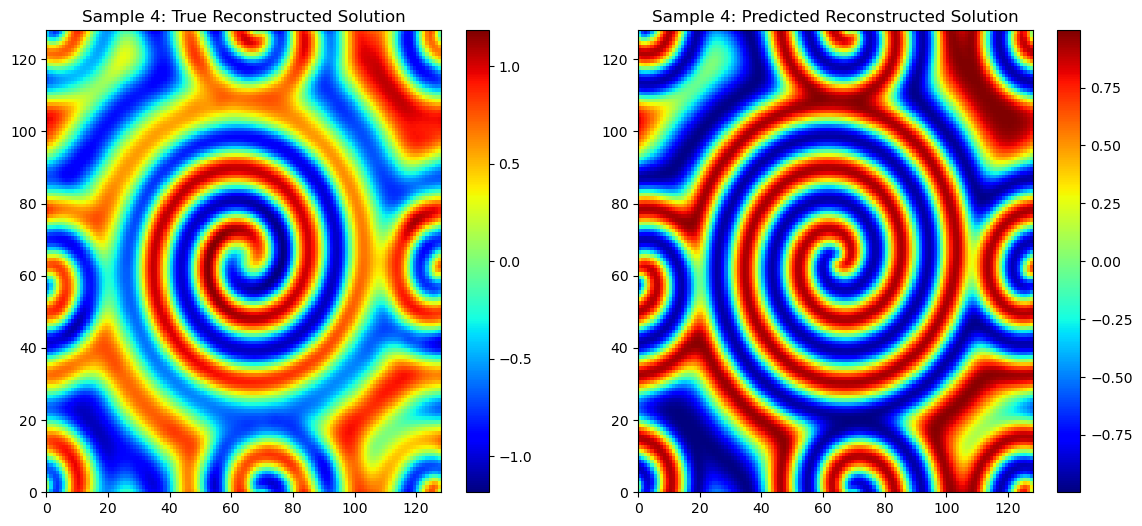

Sample 5
True Modes: [-0.00600645  0.00654502  0.00273477 -0.00300475 -0.01355964  0.00128871
  0.00771133  0.00321562  0.00530741  0.00418731 -0.00640363]
Predicted Modes: [-0.00630357  0.00596002  0.00286168 -0.00340996 -0.01362916  0.00069236
  0.0078232   0.00338125  0.00480748  0.004656   -0.00615337]


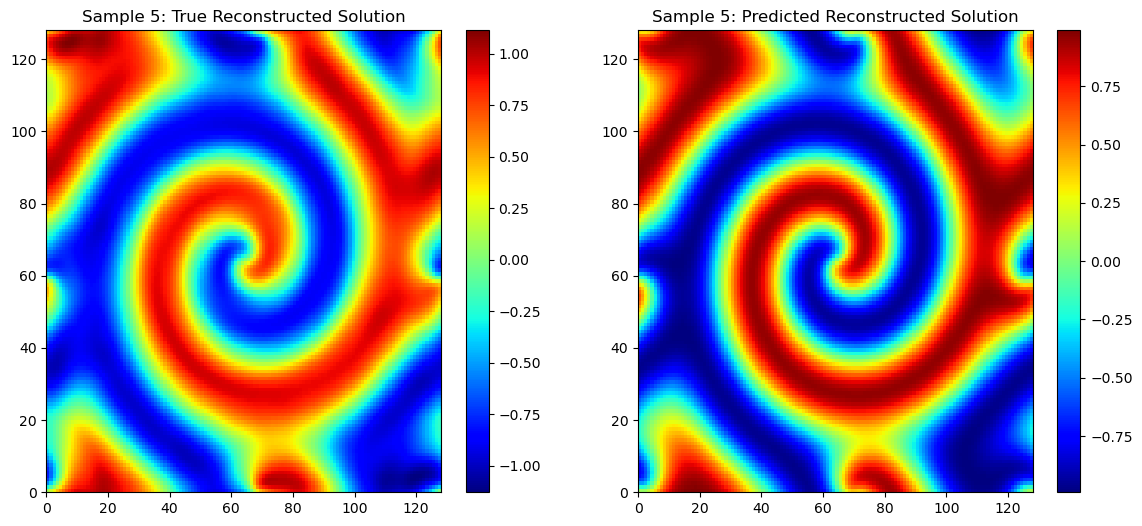

In [56]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled.reshape(-1, 11)).reshape(y_test.shape)
# Visualize results for a few test samples with reconstructed solutions
for i in range(5):  # Compare 5 samples
    true_modes = y_test[i, -1]  # Last time step's true modes
    pred_modes = y_pred[i, -1]  # Last time step's predicted modes

    # Reconstruct solutions using POD modes
    true_solution = POD_modes[:, :11] @ (Sigma[:11] * pred_modes)
    pred_solution = snapshot_plot[i,-1,:]

    # Reshape solutions to grid size
    n = int(np.sqrt(POD_modes.shape[0]))
    true_solution_grid = true_solution.reshape((n, n))
    pred_solution_grid = pred_solution.reshape((n, n))

    # Print true and predicted modes
    print(f"Sample {i + 1}")
    print(f"True Modes: {true_modes}")
    print(f"Predicted Modes: {pred_modes}")

    # Grid visualization for true and predicted solutions
    plt.figure(figsize=(14, 6))

    # True solution
    plt.subplot(1, 2, 1)
    plt.pcolormesh(true_solution_grid, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"Sample {i + 1}: True Reconstructed Solution")

    # Predicted solution
    plt.subplot(1, 2, 2)
    plt.pcolormesh(pred_solution_grid, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"Sample {i + 1}: Predicted Reconstructed Solution")

    plt.show()

In [57]:
model.save("lstm_single_fidelity.keras")

In [58]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained first-level NN
first_level_model = load_model('pod_nn_model.keras')

In [59]:
first_level_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,225 (1.34 MB)

 Trainable params: 116,741 (456.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,484 (912.05 KB)

In [70]:
first_level_model.layers[i].get_weights()

[array([[ 0.05368793,  0.17811131, -0.19762501,  0.21737336,  0.17336378,
          0.04704777,  0.17652473,  0.08476774,  0.16085006, -0.1768172 ,
          0.1249372 , -0.18784556,  0.03633453,  0.03245488, -0.11601858,
         -0.24587838, -0.06428447, -0.09519634,  0.09946886, -0.02048323,
          0.0678151 ,  0.03868385,  0.19458157, -0.1794066 , -0.147314  ,
          0.08729016,  0.0044351 ,  0.01533369, -0.19802804,  0.1426897 ,
          0.20068249,  0.120399  , -0.094048  , -0.04036608, -0.1594593 ,
          0.08155257,  0.05657315, -0.00283683,  0.07381175, -0.0214616 ,
          0.10788219, -0.07960865, -0.15437646, -0.18472041, -0.01270678,
          0.09499574, -0.12517175, -0.0155744 ,  0.18241243, -0.16761768,
          0.00899161, -0.04866036, -0.09526464,  0.05307284, -0.0730544 ,
         -0.10364995,  0.07885877,  0.07339334, -0.06896562,  0.05739498,
          0.06383044,  0.08784768,  0.02000143,  0.12888871, -0.11570895,
         -0.07479623, -0.0669805 , -0.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

# Load the pre-trained first-level model
first_level_model = load_model('pod_nn_model.keras')

# Create a new model with the same architecture for the first 4 layers
new_model = Sequential()

# Copy the first 4 layers of the original model
for i in range(4):  # 0-indexed, so layers[0] to layers[3]
    layer = first_level_model.layers[i]
    
    # Add the layer to the new model (with the same configuration)
    new_model.add(layer.__class__.from_config(layer.get_config()))

# Initialize the new model by calling it with dummy input data
dummy_input = np.random.rand(1, 3)  # Replace (1, 3) with the correct input shape
new_model(dummy_input)  # This will initialize the weights of the new model

# Copy weights and biases from the original model to the new model
for i in range(4):  # Matching layers to copy
    new_model.layers[i].set_weights(first_level_model.layers[i].get_weights())

# Make the weights non-trainable
for layer in new_model.layers:
    layer.trainable = False

# Verify the structure and trainable status
new_model.summary()

# Check if layers are trainable
for i, layer in enumerate(new_model.layers):
    print(f"Layer {i} ({layer.name}): Trainable = {layer.trainable}")

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 128)               │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 128)               │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,048 (195.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 50,048 (195.50 KB)

Layer 0 (dense): Trainable = False
Layer 1 (dense_1): Trainable = False
Layer 2 (dense_2): Trainable = False
Layer 3 (dense_3): Trainable = False


In [78]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Build the intermediate LSTM model
def build_intermediate_lstm(input_shape):
    intermediate_input = Input(shape=input_shape, name="Intermediate_LSTM_Input")
    x = Dense(128, activation='gelu', name="Dense1")(intermediate_input)
    x = Dense(128, activation='gelu', name="Dense2")(x)
    lstm1 = LSTM(128, activation='tanh', return_sequences=True, name="LSTM1")(x)
    lstm2 = LSTM(128, activation='tanh', return_sequences=True, name="LSTM2")(lstm1)
    return Model(inputs=intermediate_input, outputs=lstm2, name="Intermediate_LSTM_Model")

# Build the final concatenated model
def build_final_model(boundary_input_shape, frozen_output_shape, lstm_output_shape):
    # Inputs
    boundary_input = Input(shape=boundary_input_shape, name="Boundary_Input")  # X_train_scaled
    frozen_output_input = Input(shape=frozen_output_shape, name="Frozen_Output_Input")  # From frozen new_model
    lstm_output_input = Input(shape=lstm_output_shape, name="LSTM_Output_Input")  # From intermediate LSTM
    
    # Concatenate
    concatenated = Concatenate(name="Concatenation")([boundary_input, frozen_output_input, lstm_output_input])
    
    # Final LSTM and Dense layers
    final_lstm = LSTM(128, activation='tanh', name="Final_LSTM")(concatenated)
    output = Dense(11, activation='linear', name="Final_Output")(final_lstm)
    
    return Model(inputs=[boundary_input, frozen_output_input, lstm_output_input], outputs=output, name="Final_Model")


In [ ]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Load the pre-trained first-level NN
first_level_model = load_model('pod_nn_model.keras')

# Freeze the first-level NN to prevent retraining
for layer in first_level_model.layers:
    layer.trainable = False

# Define the input shapes
time_steps = 80  # Example: sequence length
boundary_input_shape = (time_steps, 3)  # e.g., sequence of (d1, beta, time)
frozen_output_shape = (128,)  # Output of frozen layers
lstm_output_shape = (128,)  # Output of intermediate LSTM

# Step 1: Apply the first-level NN to each time step using TimeDistributed
def build_first_level_sequence_model(first_level_model, input_shape):
    sequence_input = Input(shape=input_shape, name="Sequence_Input")
    time_distributed = TimeDistributed(first_level_model, name="Time_Distributed_First_Level")(sequence_input)
    return Model(inputs=sequence_input, outputs=time_distributed, name="First_Level_Sequence_Model")

first_level_sequence_model = build_first_level_sequence_model(first_level_model, boundary_input_shape)

# Step 2: Intermediate LSTM model
def build_intermediate_lstm(sequence_output_shape):
    lstm_input = Input(shape=sequence_output_shape, name="Intermediate_LSTM_Input")
    x = LSTM(128, activation='tanh', return_sequences=True, name="Intermediate_LSTM1")(lstm_input)
    x = LSTM(128, activation='tanh', return_sequences=True, name="Intermediate_LSTM2")(x)
    return Model(inputs=lstm_input, outputs=x, name="Intermediate_LSTM_Model")

intermediate_lstm_model = build_intermediate_lstm((time_steps, 128))

# Step 3: Final LSTM model
def build_final_model(sequence_output_shape, frozen_output_shape):
    sequence_input = Input(shape=sequence_output_shape, name="Final_Sequence_Input")
    frozen_input = Input(shape=frozen_output_shape, name="Frozen_Input")

    # Concatenate the outputs
    concatenated = Concatenate(name="Concatenation")([sequence_input, frozen_input])

    # Final LSTM and dense layer
    x = LSTM(128, activation='tanh', name="Final_LSTM")(concatenated)
    output = Dense(11, activation='linear', name="Final_Output")(x)

    return Model(inputs=[sequence_input, frozen_input], outputs=output, name="Final_Model")

final_model = build_final_model((time_steps, 128), (128,))

# Compile the final model
final_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# View model summaries
first_level_sequence_model.summary()
intermediate_lstm_model.summary()
final_model.summary()

# Generate mock data for testing
X_param_time = np.random.rand(100, time_steps, 3)  # 100 samples, 80 time steps, 3 features (d1, beta, time)
frozen_output = np.random.rand(100, 128)  # Mock frozen output

# Generate sequence output from first-level NN
sequence_output = first_level_sequence_model.predict(X_param_time)

# Generate intermediate LSTM output
intermediate_output = intermediate_lstm_model.predict(sequence_output)

# Train the final model
y_pod_modes = np.random.rand(100, 11)  # Mock target: 11 POD modes
history = final_model.fit(
    [intermediate_output, frozen_output], y_pod_modes,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[LearningRateScheduler(lambda epoch, lr: lr * 0.99)],
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 80, 128), (None, 128)]